# Visualising the Hox genes

In [1]:
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
import matplotlib.colors as mcolors

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read file, name columns
def read_aln(m8, id_sep=None):
    hox = pd.read_csv(m8, sep="\t", header=None)
    m8_columns = ['query', 'target', 'seq_id', 'ali_len', 'no_mism', 'no_go',
                'q_start', 'q_end', 't_start', 't_end', 'eval', 'bit']
    hox.columns = m8_columns
    # trim the query to just the ID
    if id_sep is not None:
        hox["query"] = hox["query"].str.split(id_sep).str[1]
    return hox

def read_gff(loc):
    gff = pd.read_csv(loc, sep="\t", header=None, skiprows=1)
    gff_columns = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    gff.columns = gff_columns
    return gff

In [4]:
gff_loc = "~/Documents/data/pycnogonum/hox.gff3"
gff = read_gff(gff_loc)

In [5]:
gff["gene"] = gff["attributes"].str.split("ID=").str[1].str.split(";").str[0].str.split(".").str[0]

In [6]:
def ends(df):
    return df["start"].min(), df["end"].max()

In [7]:
tmp = gff.groupby("gene").apply(ends)
hox = pd.DataFrame(tmp.tolist(), columns=["start", "end"], index=tmp.index)
hox["color"] = ["magenta", "royalblue", "darkmagenta", "goldenrod", "red", "orange", "green", "gold", "darkturquoise"]
hox["name"] = ["Hox1/Lb", "Hox10/AbdB", "Hox2/Pb", "Hox3", "Hox4/Dfd", "Hox5/Scr", "Hox6/Ftz", "Hox7/Antp", "Hox8/Ubx"]
hox["offset"] = [0.02, 0.02, -0.025, 0.02, 0.02, 0.02, -0.025, 0.02, 0.02]

## Manual curation of Hox genes

We have a list of putative Hox CDS for the basic 10 Hox genes (except for Abdominal A, which is
presumed missing in pycnogonids). Align against the flye assembly and manually extract the relevant
high-quality matches, to be plotted here. Also add the miRNA genes, as predicted by MirMachine for
the draft genome:

```
pseudochrom_56	MirMachine	microRNA	2121209	2121272	52.8	+	.	gene_id=Mir-10.PRE;E-value=6.1e-08;
pseudochrom_56	MirMachine	microRNA	2228728	2228791	49.4	-	.	gene_id=Mir-10.PRE;E-value=4.7e-07;
```

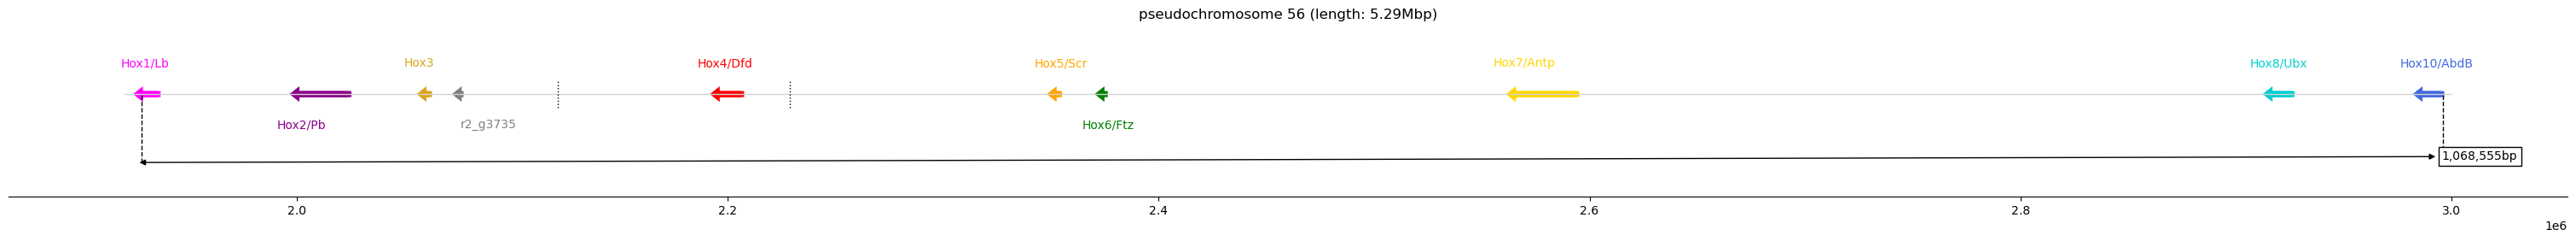

In [13]:
fig, ax = plt.subplots(figsize=(30, 2))
# plot contig
ax.plot([1920000, 3000000], [0, 0], color="lightgray", linewidth=1)

for name, gene in hox.iterrows():
    # ax.plot([gene["start"], gene["end"]], [0, 0], color=mcolors.CSS4_COLORS[gene["color"]], linewidth=10)
    start = gene["start"]
    end = gene["end"]
    ax.arrow(end, 0, start-end-1000, 0, head_width=0.05, head_length=1000, fc=mcolors.CSS4_COLORS[gene["color"]], ec=mcolors.CSS4_COLORS[gene["color"]], linewidth=5)
    ax.text(gene["start"]-10000, gene["offset"]*20, gene["name"], color=mcolors.CSS4_COLORS[gene["color"]], fontsize=10)

ax.vlines(2121209, -0.2, 0.2, color="black", linewidth=1, linestyle="dotted")
ax.vlines(2228728, -0.2, 0.2, color="black", linewidth=1, linestyle="dotted")


# ax.plot([2075916, 2076806], [0, 0], color="gray", linewidth=10)
ax.arrow(2075916, 0, 2075916-2076806, 0, head_width=0.05, head_length=1000, fc="gray", ec="gray", linewidth=5)
ax.text(2075916, -0.025*20, 'r2_g3735', color="gray", fontsize=10)

ax.vlines(1927670, -1, 0, color="k", linewidth=1, linestyle="--")
ax.vlines(2996225, -1, 0, color="k", linewidth=1, linestyle="--")

ax.annotate('1,068,555bp', xy=(1925670, -1), xytext=(3013225, -1), xycoords='data',
            fontsize=10, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='<|-|>', lw=1.0, color='k'))

# now add miRNAs

ax.set_yticks([])
ax.set_ylim(-1.5, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title(f"pseudochromosome 56 (length: 5.29Mbp)");
plt.gca().set_position([0, 0, 1, 1])
plt.savefig("figs/hox.svg", bbox_inches='tight', pad_inches=0)

1068555bp long

# AbdA search

I searched for "Araneae abdominal A" on NCBI and found a few sequences. I then used the `mmseqs
easy-search` command to map those against the genome assembly. I will now parse the results and plot
the alignments.

In [9]:
abda_loc = '/Volumes/scratch/pycnogonum/genome/draft/hox/araneae_abdA.m8'
abdA = read_aln(abda_loc)

In [10]:
names = {
    "XP_054713341.1": "abdA P. tepidariorum",
    "XP_055947933.1": "abdA, partial P. tepidariorum",
    "XP_054721767.1": "abdA, partial P. tepidariorum",
    "PRD32955.1": "abdA, partial Steatoda triangulosa",
    "BBD75264.1": "hox prot. abdA homolog A. bruennichi",
    "CAX11343.1": "hox prot. abdA homolog isoform X2 A. bruennichi",
    "PRD35417.1": "hox prot. abdA homolog isoform X1 A. bruennichi",
    "AAF73209.1": "hox prot. abdA homolog isoform X1 A. bruennichi",
    "XP_055947932.1": "hox prot. abdA homolog U. diversus",
    "XP_055947936.1": "hox prot. abdA homolog isoform X1 A. bruennichi",
    "XP_055947935.1": "hox prot. abdA homolog isoform X1 A. bruennichi",
    "XP_055947934.1": "hox prot. abdA homolog U. diversus",
    "AAF73207.1": "UNVERIFIED: abdA T. clavipes",
    "XP_055926568.1": "UNVERIFIED: abdA T. clavipes",
}

In [11]:
best = abdA.sort_values('bit').drop_duplicates('query', keep='last')
best.set_index('query', inplace=True)
best['name'] = best.index.map(names)

In [12]:
best

,target,seq_id,ali_len,no_mism,no_go,q_start,q_end,t_start,t_end,eval,bit,name
query,,,,,,,,,,,,
AAF73207.1,pseudochrom_56,0.925,81,2,0,1,26,2565363,2565283,1.096000e-07,49,UNVERIFIED: abdA T. clavipes
AAF73209.1,pseudochrom_56,0.962,81,1,0,1,27,2565363,2565283,9.690000e-10,55,hox prot. abdA homolog isoform X1 A. bruennichi
BBD75264.1,pseudochrom_56,0.866,222,10,0,138,212,2916673,2916452,8.843000e-32,130,hox prot. abdA homolog A. bruennichi
PRD35417.1,pseudochrom_56,0.866,222,10,0,8,82,2916673,2916452,5.455000e-34,130,hox prot. abdA homolog isoform X1 A. bruennichi
XP_055947933.1,pseudochrom_56,0.866,222,10,0,139,213,2916673,2916452,5.550000e-32,131,"abdA, partial P. tepidariorum"
XP_054713341.1,pseudochrom_56,0.866,222,10,0,140,214,2916673,2916452,5.910000e-32,131,abdA P. tepidariorum
XP_055926568.1,pseudochrom_56,0.788,252,18,0,162,246,2916679,2916428,3.880000e-31,131,UNVERIFIED: abdA T. clavipes
XP_055947935.1,pseudochrom_56,0.866,222,10,0,139,213,2916673,2916452,5.550000e-32,131,hox prot. abdA homolog isoform X1 A. bruennichi
XP_055947932.1,pseudochrom_56,0.866,222,10,0,139,213,2916673,2916452,5.550000e-32,131,hox prot. abdA homolog U. diversus


In [13]:
gff

,seqid,source,type,start,end,score,strand,phase,attributes,gene
0,pseudochrom_58,manual,exon,1936033,1935227,.,-,.,ID=hox1.exon1;Parent=hox1.t1;,hox1
1,pseudochrom_58,manual,exon,1928029,1927670,.,-,.,ID=hox1.exon2;Parent=hox1.t1;,hox1
2,pseudochrom_58,manual,exon,2000655,1999366,.,-,.,ID=hox2.exon1;Parent=hox2.t1;,hox2
3,pseudochrom_58,manual,exon,2024148,2023822,.,-,.,ID=hox2.exon2;Parent=hox2.t1;,hox2
4,pseudochrom_58,manual,exon,2059654,2058932,.,-,.,ID=hox3.exon1;Parent=hox3.t1;,hox3
5,pseudochrom_58,manual,exon,2061791,2061237,.,-,.,ID=hox3.exon2;Parent=hox3.t1;,hox3
6,pseudochrom_58,manual,exon,2206718,2206122,.,-,.,ID=hox4.exon1;Parent=hox4.t1;,hox4
7,pseudochrom_58,manual,exon,2195801,2195415,.,-,.,ID=hox4.exon2;Parent=hox4.t1;,hox4
8,pseudochrom_58,manual,exon,2354374,2353748,.,-,.,ID=hox5.exon1;Parent=hox5.t1;,hox5
9,pseudochrom_58,manual,exon,2352211,2351939,.,-,.,ID=hox5.exon2;Parent=hox5.t1;,hox5


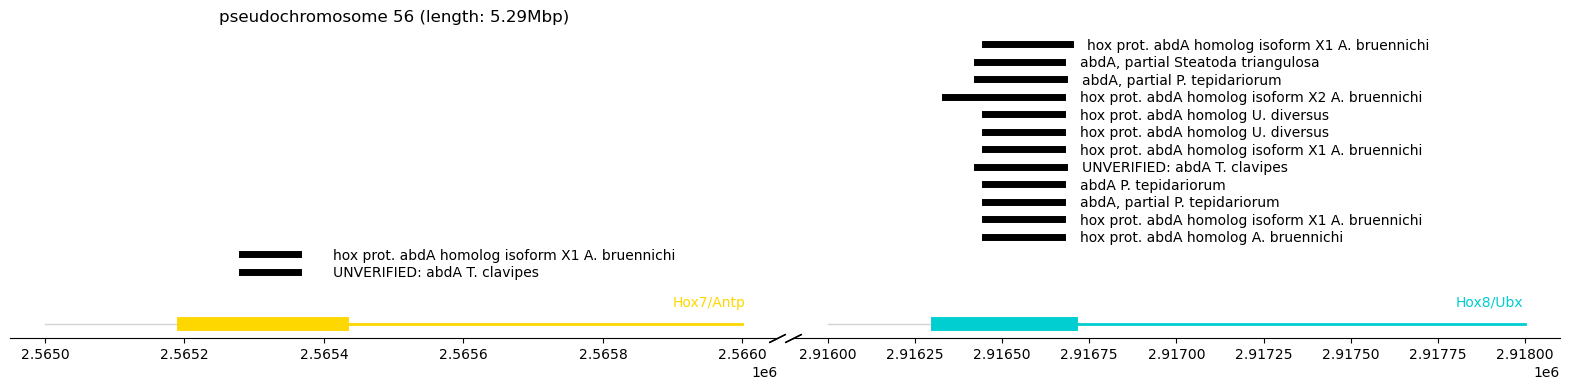

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 4))
fig.subplots_adjust(wspace=0.02)

# plot contig
ax1_end = 2566000
ax2_end = 2918000
ax1.plot([2565000, ax1_end], [0, 0], color="lightgray", linewidth=1)
ax2.plot([2916000, ax2_end], [0, 0], color="lightgray", linewidth=1)


# ax2.plot([2926445, 2925945], [0, 0], color=mcolors.CSS4_COLORS["darkturquoise"], linewidth=10)
ax2.plot([2916697, 2916317], [0, 0], color=mcolors.CSS4_COLORS["darkturquoise"], linewidth=10)
ax2.plot([ax2_end, 2916317], [0, 0], color=mcolors.CSS4_COLORS["darkturquoise"], linewidth=2)
ax2.text(ax2_end-200, 1, "Hox8/Ubx", color=mcolors.CSS4_COLORS["darkturquoise"], fontsize=10)

# ax1.plot([2594468, 2593881], [0, 0], color=mcolors.CSS4_COLORS["gold"], linewidth=10)
ax1.plot([2565426, 2565199], [0, 0], color=mcolors.CSS4_COLORS["gold"], linewidth=10)
ax1.plot([ax1_end, 2565199], [0, 0], color=mcolors.CSS4_COLORS["gold"], linewidth=2)
ax1.text(ax1_end-100, 1, "Hox7/Antp", color=mcolors.CSS4_COLORS["gold"], fontsize=10)

i=3
for name, gene in best.iterrows():
    ax = ax1
    if gene["t_start"] > 2800000:
        ax = ax2
    ax.plot([gene["t_start"], gene["t_end"]], [i, i], color="black", linewidth=5)
    ax.text(gene["t_start"]+50, i-0.3, gene["name"], color="black", fontsize=10)
    i += 1

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 0], transform=ax2.transAxes, **kwargs)

for ax in [ax1, ax2]:
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
ax1.set_title(f"pseudochromosome 56 (length: 5.29Mbp)");

fig.savefig("/Users/npapadop/Documents/presentations/2024-08_pygno_paper/suppl-abdA_araneae.png", dpi=300)